In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import tensorflow as tf

import neurodeploy as neuro

2023-03-31 11:52:27.423125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the MNIST data

In [27]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255

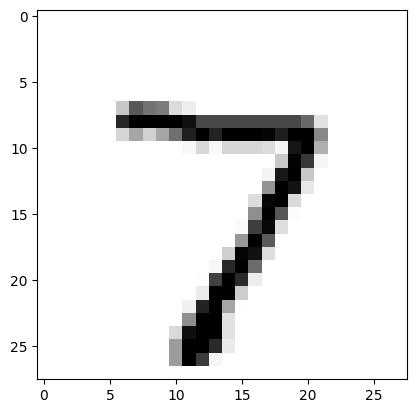

In [28]:
pyplot.imshow(x_test[0], cmap='Greys')

## Create a DNN to recognize the digits

In [58]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(x_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(8, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.metrics.SparseCategoricalAccuracy()],
    )
    return model

model = create_model()

### Train the DNN

In [59]:
model.fit(x_train, y_train, epochs=5, batch_size=1024, validation_split=0.2)

Epoch 1/5
47/47 [==============================] - 1s 7ms/step - loss: 1.9823 - sparse_categorical_accuracy: 0.3386 - val_loss: 1.6145 - val_sparse_categorical_accuracy: 0.5477
Epoch 2/5
47/47 [==============================] - 0s 4ms/step - loss: 1.4381 - sparse_categorical_accuracy: 0.6009 - val_loss: 1.2292 - val_sparse_categorical_accuracy: 0.6367
Epoch 3/5
47/47 [==============================] - 0s 4ms/step - loss: 1.1500 - sparse_categorical_accuracy: 0.6415 - val_loss: 1.0070 - val_sparse_categorical_accuracy: 0.6627
Epoch 4/5
47/47 [==============================] - 0s 4ms/step - loss: 0.9510 - sparse_categorical_accuracy: 0.6869 - val_loss: 0.8169 - val_sparse_categorical_accuracy: 0.7496
Epoch 5/5
47/47 [==============================] - 0s 4ms/step - loss: 0.7608 - sparse_categorical_accuracy: 0.7771 - val_loss: 0.6525 - val_sparse_categorical_accuracy: 0.8271


## Deploy the model with Neurodeploy

In [60]:
neuro.deploy("digits", model)

{'message': 'yout file is uploaded', 'status_code': '200'}

## Accessing the deployed ML model via requests

In [32]:
from typing import Any
import requests
import json

def preprocess(x: np.ndarray) -> list:
  x = x / 255 # normalize
  return x.reshape(1, *x.shape).tolist()

def predict(username: str, model_name: str, x: np.ndarray) -> Any:
  # get endpoint
  url = f"https://api.neurodeploy.com/{username}/{model_name}"

  # make POST request to the endpoint, passing in preprocessed data
  response = requests.post(
    url,
    headers={'Content-Type': 'application/json'},
    data=json.dumps({"payload": preprocess(x)})
  )

  # get output
  output = response.json()["output"]

  return np.argmax(output)


In [35]:
def test_k(username, model_name, k) -> bool:
    return predict(username, model_name, x_test[k]) == y_test[k]

In [62]:
k, val = -1, True
while val:
    k += 1
    val = test_k('vincent', 'digits', k)
    print(f"{k}: {val}")

0: True
1: True
2: True
3: True
4: True
5: True
6: False



k: 6
guess: 9
actual: 4



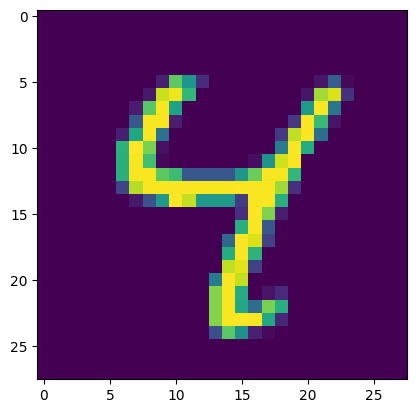

In [72]:
pyplot.imshow(x_test[k])
print(f"""
k: {k}
guess: {predict('vincent', 'digits', x_test[k])}
actual: {y_test[k]}
""")

(4, 9)